Device: cuda


Saving megares_fasta_processed.csv to megares_fasta_processed.csv
Loaded: megares_fasta_processed.csv
Original rows: 8733
Columns: ['gene_id', 'header', 'sequence', 'seq_len', 'gc_content', 'type', 'drug_class', 'mechanism', 'group']
After dedup / dropna: 8733
Kept groups >= 8: 123 groups, rows now 6503
k-mer vocab size: 4097
Encoding sequences to 6-mer indices (this may take a minute)...


100%|██████████| 6503/6503 [00:01<00:00, 5459.83it/s]


Done encoding. Example shape: (512,)
Global classes: groups=123, mechanisms=48, drug_classes=22
Split sizes: train=4551, val=976, test=976
HybridEncoderMultiTask(
  (embed): Embedding(4097, 64, padding_idx=0)
  (conv1): Conv1d(64, 128, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv_pool): AdaptiveMaxPool1d(output_size=32)
  (lstm): LSTM(128, 256, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (head_group): Linear(in_features=512, out_features=123, bias=True)
  (head_mech): Linear(in_features=512, out_features=48, bias=True)
  (head_class): Linear(in_features=512, out_features=22, bias=True)
)
Model output sizes: group=123, mech=48, class=22


Epoch 1 train: 100%|██████████| 36/36 [00:02<00:00, 14.55it/s]


Epoch 1 TRAIN loss=5.7116 group_acc=0.2010 mech_acc=0.2901 class_acc=0.6353
Epoch 1  VAL  loss=4.8293 group_acc=0.3049 mech_acc=0.5104 class_acc=0.6781
Saved best model.


Epoch 2 train: 100%|██████████| 36/36 [00:01<00:00, 34.42it/s]


Epoch 2 TRAIN loss=4.1857 group_acc=0.4278 mech_acc=0.5331 class_acc=0.6723
Epoch 2  VAL  loss=3.5189 group_acc=0.5393 mech_acc=0.6244 class_acc=0.7004
Saved best model.


Epoch 3 train: 100%|██████████| 36/36 [00:01<00:00, 34.45it/s]


Epoch 3 TRAIN loss=3.1073 group_acc=0.5720 mech_acc=0.6676 class_acc=0.7308
Epoch 3  VAL  loss=2.7271 group_acc=0.6084 mech_acc=0.7057 class_acc=0.7523
Saved best model.


Epoch 4 train: 100%|██████████| 36/36 [00:01<00:00, 34.38it/s]


Epoch 4 TRAIN loss=2.3850 group_acc=0.6532 mech_acc=0.7483 class_acc=0.7833
Epoch 4  VAL  loss=2.2322 group_acc=0.6703 mech_acc=0.7375 class_acc=0.7930
Saved best model.


Epoch 5 train: 100%|██████████| 36/36 [00:01<00:00, 32.52it/s]


Epoch 5 TRAIN loss=1.8669 group_acc=0.7255 mech_acc=0.8074 class_acc=0.8323
Epoch 5  VAL  loss=1.8447 group_acc=0.7502 mech_acc=0.7965 class_acc=0.8313
Saved best model.


Epoch 6 train: 100%|██████████| 36/36 [00:01<00:00, 31.93it/s]


Epoch 6 TRAIN loss=1.4103 group_acc=0.7963 mech_acc=0.8584 class_acc=0.8805
Epoch 6  VAL  loss=1.6087 group_acc=0.7721 mech_acc=0.8238 class_acc=0.8469
Saved best model.


Epoch 7 train: 100%|██████████| 36/36 [00:01<00:00, 33.99it/s]


Epoch 7 TRAIN loss=1.1082 group_acc=0.8463 mech_acc=0.8955 class_acc=0.9044
Epoch 7  VAL  loss=1.4714 group_acc=0.8162 mech_acc=0.8445 class_acc=0.8674
Saved best model.


Epoch 8 train: 100%|██████████| 36/36 [00:01<00:00, 34.15it/s]


Epoch 8 TRAIN loss=0.8846 group_acc=0.8732 mech_acc=0.9181 class_acc=0.9265
Epoch 8  VAL  loss=1.3487 group_acc=0.8295 mech_acc=0.8514 class_acc=0.8734
Saved best model.
TEST accuracies -> group: 0.8285156264901161 mechanism: 0.8673828169703484 drug_class: 0.9013671875
t-SNE (this may take ~30-90s depending on CPU/GPU)...


/tmp/ipython-input-3749286967.py:302: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


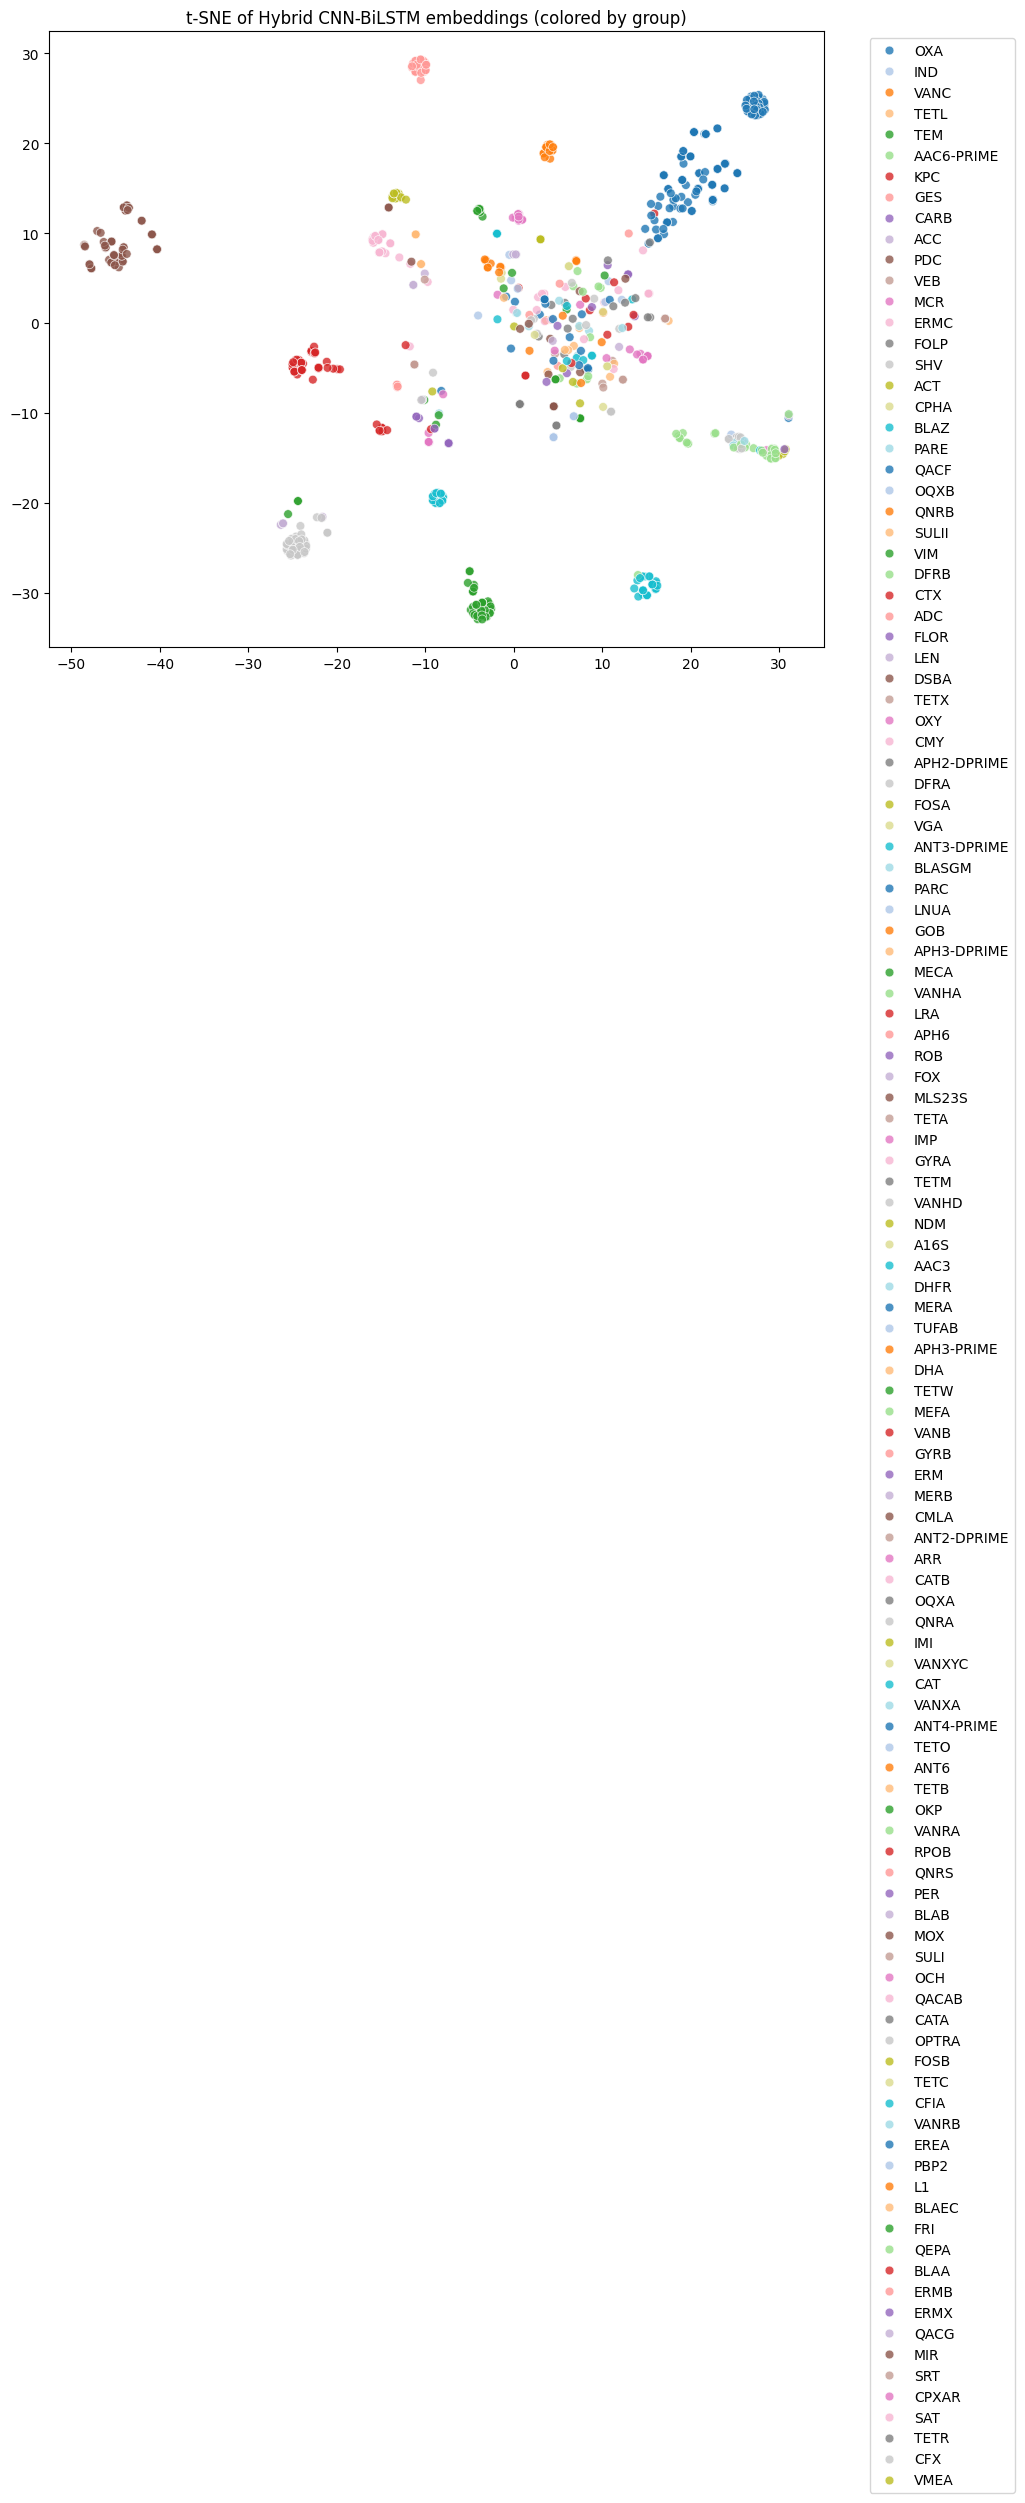

Finished.


In [ ]:
# ============================================================
# Colab-ready: Hybrid CNN -> BiLSTM Multi-task Classifier
# (6-mer encoding, multi-head: group / mechanism / drug_class)
# FIXED: Proper label handling for train/val/test splits
# ============================================================

# Install (Colab already usually has these)
!pip install torch torchvision tqdm scikit-learn matplotlib > /dev/null

import os
import numpy as np
import pandas as pd
from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# -------------------------
# Device
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -------------------------
# 1) Load CSV (upload)
# -------------------------
from google.colab import files
uploaded = files.upload()
csv_name = list(uploaded.keys())[0]
print("Loaded:", csv_name)

df = pd.read_csv(csv_name)
print("Original rows:", df.shape[0])
print("Columns:", df.columns.tolist())

# Required columns check
required = ['sequence', 'drug_class', 'mechanism', 'group']
for c in required:
    if c not in df.columns:
        raise ValueError(f"Required column missing: {c}")

# Basic cleaning
df = df.dropna(subset=required).copy()
df['sequence'] = df['sequence'].astype(str).str.upper()
df = df.drop_duplicates(subset=['sequence','group'])
print("After dedup / dropna:", df.shape[0])

# -------------------------
# 2) Filter very small groups (optional)
# -------------------------
min_samples = 8
group_counts = df['group'].value_counts()
valid_groups = group_counts[group_counts >= min_samples].index
df = df[df['group'].isin(valid_groups)].reset_index(drop=True)
print(f"Kept groups >= {min_samples}: {len(valid_groups)} groups, rows now {len(df)}")

# -------------------------
# 3) Build 6-mer vocabulary and encode sequences
# -------------------------
k = 6
max_kmer_len = 512
kmers = [''.join(p) for p in product('ACGT', repeat=k)]
kmer_to_idx = {kmer: i+1 for i, kmer in enumerate(kmers)}
vocab_size = len(kmers) + 1
print("k-mer vocab size:", vocab_size)

def revcomp(seq):
    table = str.maketrans('ACGTacgt', 'TGCAtgca')
    return seq.translate(table)[::-1]

def encode_kmers(seq, k=k, max_len=max_kmer_len, augment=False):
    if augment and np.random.rand() < 0.5:
        seq = revcomp(seq)
    seq = seq.replace('N', '')
    toks = [seq[i:i+k] for i in range(0, len(seq)-k+1)]
    ids = [kmer_to_idx.get(t, 0) for t in toks[:max_len]]
    if len(ids) < max_len:
        ids += [0] * (max_len - len(ids))
    return np.array(ids, dtype=np.int64)

print("Encoding sequences to 6-mer indices (this may take a minute)...")
encoded = []
for s in tqdm(df['sequence'].values):
    encoded.append(encode_kmers(s, augment=False))
df['encoded_seq'] = encoded
print("Done encoding. Example shape:", df['encoded_seq'].iloc[0].shape)

# -------------------------
# 4) GLOBAL Label encoding (keep original mapping)
# -------------------------
group_le = LabelEncoder()
mech_le = LabelEncoder()
class_le = LabelEncoder()

df['group_label'] = group_le.fit_transform(df['group'])
df['mech_label']  = mech_le.fit_transform(df['mechanism'])
df['class_label'] = class_le.fit_transform(df['drug_class'])

n_group_global = df['group_label'].nunique()
n_mech_global  = df['mech_label'].nunique()
n_class_global = df['class_label'].nunique()
print(f"Global classes: groups={n_group_global}, mechanisms={n_mech_global}, drug_classes={n_class_global}")

# -------------------------
# 5) Train/Val/Test split
# -------------------------
# Split by samples, stratified by group
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(df, test_size=0.15, random_state=42, stratify=df['group_label'])
train, val = train_test_split(train_val, test_size=0.1765, random_state=42, stratify=train_val['group_label'])

df_train = train.reset_index(drop=True)
df_val = val.reset_index(drop=True)
df_test = test.reset_index(drop=True)

print(f"Split sizes: train={len(df_train)}, val={len(df_val)}, test={len(df_test)}")

# -------------------------
# 6) PyTorch Dataset & DataLoader
# -------------------------
class SeqDataset(torch.utils.data.Dataset):
    def __init__(self, df, augment=False):
        self.enc = np.stack(df['encoded_seq'].values)
        self.group = df['group_label'].values.astype(np.int64)
        self.mech  = df['mech_label'].values.astype(np.int64)
        self.cls   = df['class_label'].values.astype(np.int64)
        self.augment = augment
    def __len__(self): return len(self.group)
    def __getitem__(self, idx):
        x = self.enc[idx]
        if self.augment and np.random.rand() < 0.5:
            x = x[::-1].copy()
        return torch.tensor(x).long(), torch.tensor(self.group[idx]).long(), \
               torch.tensor(self.mech[idx]).long(), torch.tensor(self.cls[idx]).long()

batch_size = 128
train_ds = SeqDataset(df_train, augment=True)
val_ds   = SeqDataset(df_val, augment=False)
test_ds  = SeqDataset(df_test, augment=False)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader   = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# -------------------------
# 7) Model: Hybrid CNN -> BiLSTM encoder + multi-heads
# -------------------------
class HybridEncoderMultiTask(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, conv_channels=128, lstm_hidden=256,
                 n_group=100, n_mech=10, n_class=10, kmer_seq_len=512):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.conv1 = nn.Conv1d(embed_dim, conv_channels, kernel_size=7, padding=3)
        self.conv2 = nn.Conv1d(conv_channels, conv_channels, kernel_size=5, padding=2)
        self.conv_pool = nn.AdaptiveMaxPool1d(max(1, kmer_seq_len//16))
        self.lstm = nn.LSTM(conv_channels, lstm_hidden, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        feat_dim = lstm_hidden * 2
        self.head_group = nn.Linear(feat_dim, n_group)
        self.head_mech  = nn.Linear(feat_dim, n_mech)
        self.head_class = nn.Linear(feat_dim, n_class)

    def forward(self, x, return_feats=False):
        e = self.embed(x)
        e = e.permute(0, 2, 1)
        c = F.relu(self.conv1(e))
        c = F.relu(self.conv2(c))
        c = c.permute(0, 2, 1)
        pooled = self.conv_pool(c.permute(0,2,1)).permute(0,2,1)
        lstm_out, _ = self.lstm(pooled)
        feats = lstm_out[:, -1, :]
        feats = self.dropout(feats)
        if return_feats:
            return feats
        g = self.head_group(feats)
        m = self.head_mech(feats)
        cl = self.head_class(feats)
        return g, m, cl

# Instantiate with GLOBAL class counts
model = HybridEncoderMultiTask(
    vocab_size=vocab_size,
    embed_dim=64,
    conv_channels=128,
    lstm_hidden=256,
    n_group=n_group_global,
    n_mech=n_mech_global,
    n_class=n_class_global,
    kmer_seq_len=max_kmer_len
).to(device)

print(model)
print(f"Model output sizes: group={n_group_global}, mech={n_mech_global}, class={n_class_global}")

# -------------------------
# 8) Training utilities
# -------------------------
optimizer = optim.Adam(model.parameters(), lr=1e-3)
ce = nn.CrossEntropyLoss()

def compute_metrics(preds, labels):
    p = preds.argmax(dim=1)
    acc = (p == labels).float().mean().item()
    return acc

# -------------------------
# 9) Training loop (multi-task)
# -------------------------
n_epochs = 8
best_val = -1.0

for epoch in range(1, n_epochs+1):
    model.train()
    train_loss = 0.0
    g_accs = []; m_accs = []; c_accs = []
    for xb, y_group, y_mech, y_class in tqdm(train_loader, desc=f"Epoch {epoch} train"):
        xb = xb.to(device); yg = y_group.to(device); ym = y_mech.to(device); yc = y_class.to(device)
        optimizer.zero_grad()
        out_g, out_m, out_c = model(xb)
        loss_g = ce(out_g, yg)
        loss_m = ce(out_m, ym)
        loss_c = ce(out_c, yc)
        loss = loss_g * 1.0 + loss_m * 0.5 + loss_c * 0.3
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
        g_accs.append(compute_metrics(out_g, yg))
        m_accs.append(compute_metrics(out_m, ym))
        c_accs.append(compute_metrics(out_c, yc))
    train_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch} TRAIN loss={train_loss:.4f} group_acc={np.mean(g_accs):.4f} mech_acc={np.mean(m_accs):.4f} class_acc={np.mean(c_accs):.4f}")

    model.eval()
    val_loss = 0.0
    g_accs=[]; m_accs=[]; c_accs=[]
    with torch.no_grad():
        for xb, y_group, y_mech, y_class in val_loader:
            xb = xb.to(device); yg=y_group.to(device); ym=y_mech.to(device); yc=y_class.to(device)
            out_g, out_m, out_c = model(xb)
            loss_g = ce(out_g, yg); loss_m = ce(out_m, ym); loss_c = ce(out_c, yc)
            loss = loss_g * 1.0 + loss_m * 0.5 + loss_c * 0.3
            val_loss += loss.item() * xb.size(0)
            g_accs.append(compute_metrics(out_g, yg))
            m_accs.append(compute_metrics(out_m, ym))
            c_accs.append(compute_metrics(out_c, yc))
    val_loss /= len(val_loader.dataset)
    val_g = np.mean(g_accs); val_m = np.mean(m_accs); val_c = np.mean(c_accs)
    print(f"Epoch {epoch}  VAL  loss={val_loss:.4f} group_acc={val_g:.4f} mech_acc={val_m:.4f} class_acc={val_c:.4f}")

    if val_g > best_val:
        best_val = val_g
        torch.save(model.state_dict(), "best_hybrid_multitask.pt")
        print("Saved best model.")

# -------------------------
# 10) Load best model and test
# -------------------------
model.load_state_dict(torch.load("best_hybrid_multitask.pt", map_location=device))
model.to(device)
model.eval()

g_accs=[]; m_accs=[]; c_accs=[]
with torch.no_grad():
    for xb, y_group, y_mech, y_class in test_loader:
        xb = xb.to(device); yg=y_group.to(device); ym=y_mech.to(device); yc=y_class.to(device)
        out_g, out_m, out_c = model(xb)
        g_accs.append(compute_metrics(out_g, yg))
        m_accs.append(compute_metrics(out_m, ym))
        c_accs.append(compute_metrics(out_c, yc))

print("TEST accuracies -> group:", np.mean(g_accs), "mechanism:", np.mean(m_accs), "drug_class:", np.mean(c_accs))

# -------------------------
# 11) Collect embeddings and run t-SNE (color by group)
# -------------------------
def collect_embeddings(df_sample, model, n_max=1000):
    model.eval()
    sample = df_sample.sample(min(n_max, len(df_sample))).reset_index(drop=True)
    X = np.stack(sample['encoded_seq'].values)
    with torch.no_grad():
        feats = model(torch.tensor(X).long().to(device), return_feats=True).cpu().numpy()
    labels = sample['group'].values
    return feats, labels

feats, labels = collect_embeddings(df_test, model, n_max=800)
print("t-SNE (this may take ~30-90s depending on CPU/GPU)...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced = tsne.fit_transform(feats)

plt.figure(figsize=(10,8))
sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=labels, legend='full', palette='tab20', s=40, alpha=0.8)
plt.title("t-SNE of Hybrid CNN-BiLSTM embeddings (colored by group)")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', ncol=1)
plt.tight_layout()
plt.show()

print("Finished.")

[t-SNE] Using 371 samples from test across 10 mechanisms.


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



=== t-SNE Diagnostic Summary (Hybrid CNN-BiLSTM) ===
Points visualized:         371
Unique mechanisms:       10
Embedding dim:             512
Silhouette score:          0.386
Mean intra-class dist:     5.654
Mean inter-class dist:     21.384
Inter / Intra ratio:       3.782
ARI (KMeans vs true):      0.716
NMI (KMeans vs true):      0.787



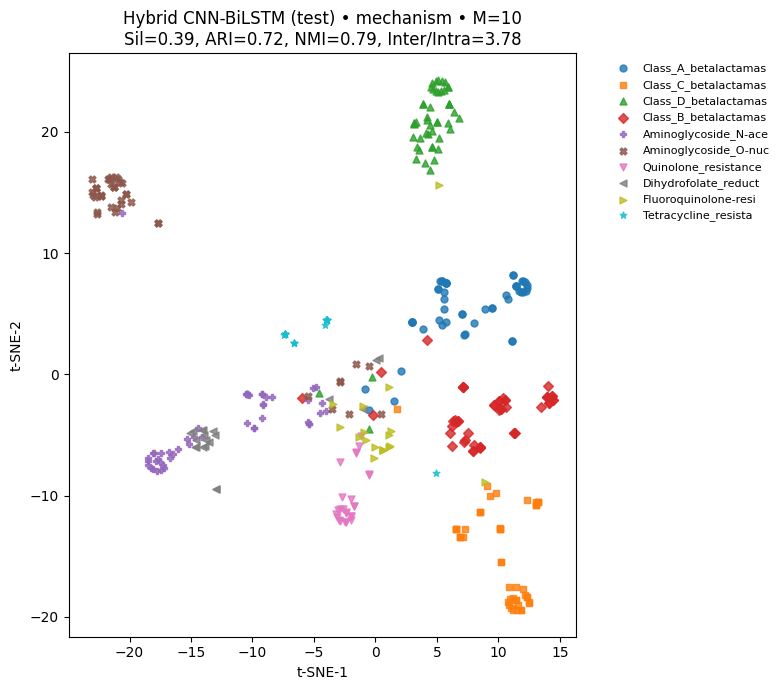

In [ ]:
# ================================================
# 🔍 t-SNE + Diagnostics for Hybrid CNN–BiLSTM model
# (no need for saved weights — uses current model)
# ================================================

from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

LABEL_COL      = "mechanism"   # can be "group" or "drug_class"
SUBSET_SOURCE  = "test"        # {"train","val","test","all"}
TOP_M_CLASSES  = 10
N_PER_CLASS    = 50
TSNE_PERPLEX   = 30
RANDOM_STATE   = 42

# -----------------------------
# 1️⃣ Choose subset of dataframe
# -----------------------------
base_df = {"train": df_train, "val": df_val, "test": df_test}.get(SUBSET_SOURCE, df)
counts = base_df[LABEL_COL].value_counts()
kept_labels = counts.head(TOP_M_CLASSES).index.tolist()

subset_list = []
for lab in kept_labels:
    sub = base_df[base_df[LABEL_COL] == lab]
    if len(sub) > N_PER_CLASS:
        sub = sub.sample(N_PER_CLASS, random_state=RANDOM_STATE)
    subset_list.append(sub)
subset = pd.concat(subset_list).reset_index(drop=True)
print(f"[t-SNE] Using {len(subset)} samples from {SUBSET_SOURCE} across {len(kept_labels)} {LABEL_COL}s.")

# -----------------------------
# 2️⃣ Get embeddings from model
# -----------------------------
tok = np.stack(subset["encoded_seq"].values)
with torch.no_grad():
    Xt = torch.tensor(tok).long().to(device)
    feats = model(Xt, return_feats=True).cpu().numpy()

Z = feats
num_points, emb_before = Z.shape
num_classes = len(np.unique(subset[LABEL_COL].values))

# -----------------------------
# 3️⃣ Run t-SNE
# -----------------------------
perplexity = min(TSNE_PERPLEX, max(5, len(Z)//4 - 1))
tsne = TSNE(
    n_components=2,
    perplexity=perplexity,
    metric="euclidean",
    init="pca",
    learning_rate="auto",
    n_iter=1000,
    random_state=RANDOM_STATE,
)
Z2 = tsne.fit_transform(Z)

# -----------------------------
# 4️⃣ Clustering diagnostics
# -----------------------------
y_str = subset[LABEL_COL].values
label_to_int = {lab: i for i, lab in enumerate(kept_labels)}
y_int = np.array([label_to_int[v] for v in y_str])

sil = silhouette_score(Z2, y_int) if num_classes > 1 else np.nan
kmeans = KMeans(n_clusters=num_classes, n_init="auto", random_state=RANDOM_STATE)
pred = kmeans.fit_predict(Z2)
ari = adjusted_rand_score(y_int, pred)
nmi = normalized_mutual_info_score(y_int, pred)

D = pairwise_distances(Z2)
intra = [D[i, y_int == y_int[i]].mean() for i in range(num_points)]
inter = [D[i, y_int != y_int[i]].mean() for i in range(num_points)]
mean_intra = float(np.nanmean(intra))
mean_inter = float(np.nanmean(inter))
ratio = mean_inter / mean_intra if mean_intra > 0 else np.nan

print("\n=== t-SNE Diagnostic Summary (Hybrid CNN-BiLSTM) ===")
print(f"Points visualized:         {num_points}")
print(f"Unique {LABEL_COL}s:       {num_classes}")
print(f"Embedding dim:             {emb_before}")
print(f"Silhouette score:          {sil:.3f}")
print(f"Mean intra-class dist:     {mean_intra:.3f}")
print(f"Mean inter-class dist:     {mean_inter:.3f}")
print(f"Inter / Intra ratio:       {ratio:.3f}")
print(f"ARI (KMeans vs true):      {ari:.3f}")
print(f"NMI (KMeans vs true):      {nmi:.3f}")
print("======================================================\n")

plt.figure(figsize=(8,7))
markers = ["o","s","^","D","P","X","v","<",">","*"]
for i, lab in enumerate(kept_labels):
    idx = (y_str == lab)
    plt.scatter(
        Z2[idx, 0], Z2[idx, 1],
        s=25,
        marker=markers[i % len(markers)],
        alpha=0.8,
        label=str(lab)[:20],
    )

plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.title(
    f"Hybrid CNN-BiLSTM ({SUBSET_SOURCE}) • {LABEL_COL} • M={num_classes}\n"
    f"Sil={sil:.2f}, ARI={ari:.2f}, NMI={nmi:.2f}, Inter/Intra={ratio:.2f}"
)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize=8, frameon=False)
plt.tight_layout()
plt.show()
